Advantages in international football

The purpose of this project is to explore how FIFA ranking, population and at which ground the game is played at (Home/Away/Neutral) affects the outcome of a match in international football. We want to explore if there are any advantages by playing at home, having population and having a higher ranking. We will be looking at how these factors can affect win percentage, average points per match and changes in goal difference. 

Our data is based on three different datasets that we have combined. The combined data describes international football matches since 1992, the population of the countries that play and their ranking at the time. We will have four different versions of the combined data set. One with the full data, one without friendlies, one without neutral matches, and one without both friendlies and neutral matches.

Course of action:
1) We will clean the data by removing row with any missing values.
2) Split the data into the 4 versions.
3) Use unsupervised learning to remove potential outliers and give us a better understanding of the data.
4) Statiscally analyse the data to see if it suggests the existince of a home advantage and if impact of said advantage would be more pronounced in some data sets than others.
5) Create models using supervised learning to help us predict the outcoome of a match based on who is playing at home, population of the countries, and their FIFA ranking. The chosen models are linear regression, random forest regression, and logistic regression.
6) Conclude on our results.

In the making of this project we have used an AI-tool (ChatGPT) to help improve our code base, writing comments, general bug fixing, and used as a partner for discussing ideas and results.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import statsmodels.api as sm
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    confusion_matrix,
    classification_report
)


populationCsvPath = 'CsvFilesExam/world_population.csv'
resultsCsvPath = 'CsvFilesExam/results.csv'
rankingCsvPath = 'CsvFilesExam/fifa_mens_rank.csv'
mergedDataCsvPath = 'CsvFilesExam/merged_data.csv'

populationData = pd.read_csv(populationCsvPath)
resultsData = pd.read_csv(resultsCsvPath)
rankingData = pd.read_csv(rankingCsvPath)



In [2]:
def load_or_create_merged_data(results_path, population_path, ranking_path, merged_output_path):
    """
    Loads merged data if it exists, otherwise creates it and saves to CSV.
    """
    if os.path.exists(merged_output_path):
        print(f"Loading existing merged dataset from {merged_output_path}...")
        mergedData = pd.read_csv(merged_output_path)
        
        mergedData['date'] = pd.to_datetime(mergedData['date'])
        
    else:
        print("Merged dataset not found, creating merged data...")
        
        # Load original data
        resultsData = pd.read_csv(results_path)
        populationData = pd.read_csv(population_path)
        rankingData = pd.read_csv(ranking_path)
        
        # Merge
        mergedData = add_population_and_ranking_to_results(resultsData, populationData, rankingData)
        
        # Save merged dataset
        mergedData.to_csv(merged_output_path, index=False)
        print(f"Merged dataset created and saved to {merged_output_path}")
    
    return mergedData

def add_population_and_ranking_to_results(results: pd.DataFrame, 
                                          world_population: pd.DataFrame, 
                                          ranking_data: pd.DataFrame) -> pd.DataFrame:
    # Parse dates
    results['date'] = pd.to_datetime(results['date'])
    ranking_data['date'] = pd.to_datetime(ranking_data['date'])

    # Extract year from match date
    results['year'] = results['date'].dt.year

    # Rename country column for easier matching
    world_population = world_population.rename(columns={'Country/Territory': 'Country'})

    # Define available years in world_population
    available_years = [2022, 2020, 2015, 2010, 2000, 1990, 1980, 1970]

    # Helper function to find best available year
    def closest_year(match_year):
        for y in sorted(available_years, reverse=True):
            if match_year >= y:
                return y
        return min(available_years)

    # Apply closest year
    results['population_year'] = results['year'].apply(closest_year)

    # Prepare population data
    pop_data = {}
    for _, row in world_population.iterrows():
        pop_data[row['Country']] = {year: row.get(f'{year} Population') for year in available_years}

    # Function to get population
    def get_population(team, year):
        country_data = pop_data.get(team)
        if country_data:
            return country_data.get(year)
        return None

    results['home_population'] = results.apply(lambda row: get_population(row['home_team'], row['population_year']), axis=1)
    results['away_population'] = results.apply(lambda row: get_population(row['away_team'], row['population_year']), axis=1)

    # ---------------------------------------
    # Add home_ranking and away_ranking
    # ---------------------------------------

    # Prepare: for easier lookup, sort ranking_data
    ranking_data = ranking_data.sort_values('date')

    def find_latest_ranking(team, match_date):
        team_rankings = ranking_data[ranking_data['team'] == team]  # fixed!
        team_rankings = team_rankings[team_rankings['date'] <= match_date]
        if not team_rankings.empty:
            return team_rankings.iloc[-1]['rank']
        else:
            return None

    # Apply for home and away teams
    results['home_ranking'] = results.apply(lambda row: find_latest_ranking(row['home_team'], row['date']), axis=1)
    results['away_ranking'] = results.apply(lambda row: find_latest_ranking(row['away_team'], row['date']), axis=1)

    # Clean up helper columns
    results = results.drop(columns=['year', 'population_year'])

    return results


def remove_nan_population_rows(results: pd.DataFrame) -> pd.DataFrame:
    # Remove rows where home_population or away_population is NaN
    results = results.dropna(subset=['home_population', 'away_population'])
    return results

def remove_nan_fifa_ranking_rows(results: pd.DataFrame) -> pd.DataFrame:
    # Remove rows where home_population or away_population is NaN
    results = results.dropna(subset=['home_ranking', 'away_ranking'])
    return results    

  

In [3]:
#This takes quite a while - comment to be deleted
print('Creating merged data')
mergedData = load_or_create_merged_data(resultsCsvPath, populationCsvPath, rankingCsvPath, mergedDataCsvPath)
print(mergedData.describe())

Creating merged data
Loading existing merged dataset from CsvFilesExam/merged_data.csv...
                                date    home_score    away_score  \
count                          48207  48207.000000  48207.000000   
mean   1993-07-18 08:20:38.459144832      1.759890      1.182048   
min              1872-11-30 00:00:00      0.000000      0.000000   
25%              1979-11-01 12:00:00      1.000000      0.000000   
50%              2000-01-24 00:00:00      1.000000      1.000000   
75%              2012-09-07 00:00:00      2.000000      2.000000   
max              2025-03-25 00:00:00     31.000000     21.000000   
std                              NaN      1.774537      1.401071   

       home_population  away_population  home_ranking  away_ranking  
count     4.373400e+04     4.347100e+04  36139.000000  36141.000000  
mean      3.251719e+07     2.721746e+07     80.960486     83.264077  
min       5.640000e+02     5.960000e+02      1.000000      1.000000  
25%       2.95375

In [4]:

# 1. Remove Friendlies
mergedData_no_friendlies = mergedData[mergedData['tournament'] != 'Friendly'].copy()

# 2. Remove Neutral Matches
mergedData_no_neutral = mergedData[mergedData['neutral'] == False].copy()

# 3. Remove Friendlies AND Neutral Matches
mergedData_no_friendlies_no_neutral = mergedData[
    (mergedData['tournament'] != 'Friendly') & (mergedData['neutral'] == False)].copy()

# Optional: print quick summaries
print(f"Original dataset size: {mergedData.shape[0]} matches")
print(f"Without Friendlies: {mergedData_no_friendlies.shape[0]} matches")
print(f"Without Neutral Matches: {mergedData_no_neutral.shape[0]} matches")
print(f"Without Friendlies AND Neutral Matches: {mergedData_no_friendlies_no_neutral.shape[0]} matches")


Original dataset size: 48207 matches
Without Friendlies: 30137 matches
Without Neutral Matches: 35515 matches
Without Friendlies AND Neutral Matches: 20010 matches


In [5]:
def determine_result(row):
    if row['home_score'] > row['away_score']:
        return 'home_win'
    elif row['home_score'] < row['away_score']:
        return 'away_win'
    else:
        return 'draw'
        
def calculate_points(results: pd.DataFrame) -> pd.DataFrame:
    def home_points(row):
        if row['outcome'] == 'home_win':
            return 3
        elif row['outcome'] == 'draw':
            return 1
        else:
            return 0

    def away_points(row):
        if row['outcome'] == 'away_win':
            return 3
        elif row['outcome'] == 'draw':
            return 1
        else:
            return 0

    results['home_points'] = results.apply(home_points, axis=1)
    results['away_points'] = results.apply(away_points, axis=1)

    average_home_points = results['home_points'].mean()
    average_away_points = results['away_points'].mean()

    print(f"Average points earned by home teams: {average_home_points:.2f} per match")
    print(f"Average points earned by away teams: {average_away_points:.2f} per match")

    return results

def plot_home_advantage(results: pd.DataFrame) -> None:
    """
    Plots a pie chart of match outcomes and a histogram of goal differences
    for home teams based on the provided results DataFrame.
    """
    # Pie chart of match outcomes
    results['outcome'].value_counts().plot(kind='pie', autopct='%1.1f%%')
    plt.title('Home Team Match Outcomes')
    plt.ylabel('')  # Remove y-axis label for cleaner pie chart
    plt.show()

    # Histogram of home team goal difference
    plt.hist(results['goal_difference'], bins=30, edgecolor='black')
    plt.title('Distribution of Home Team Goal Difference')
    plt.xlabel('Goal Difference (Home - Away)')
    plt.ylabel('Number of Matches')
    plt.show()
    

In [6]:
print("--- Original mergedData ---")
mergedData['outcome'] = mergedData.apply(determine_result, axis=1)
outcome_counts = mergedData['outcome'].value_counts(normalize=True) * 100
print(outcome_counts)

print("\n--- No Friendlies ---")
mergedData_no_friendlies['outcome'] = mergedData_no_friendlies.apply(determine_result, axis=1)
outcome_counts_no_friendlies = mergedData_no_friendlies['outcome'].value_counts(normalize=True) * 100
print(outcome_counts_no_friendlies)

print("\n--- No Neutral Matches ---")
mergedData_no_neutral['outcome'] = mergedData_no_neutral.apply(determine_result, axis=1)
outcome_counts_no_neutral = mergedData_no_neutral['outcome'].value_counts(normalize=True) * 100
print(outcome_counts_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
mergedData_no_friendlies_no_neutral['outcome'] = mergedData_no_friendlies_no_neutral.apply(determine_result, axis=1)
outcome_counts_no_friendlies_no_neutral = mergedData_no_friendlies_no_neutral['outcome'].value_counts(normalize=True) * 100
print(outcome_counts_no_friendlies_no_neutral)


--- Original mergedData ---
outcome
home_win    49.048893
away_win    28.228266
draw        22.722841
Name: proportion, dtype: float64

--- No Friendlies ---
outcome
home_win    50.087932
away_win    28.576169
draw        21.335899
Name: proportion, dtype: float64

--- No Neutral Matches ---
outcome
home_win    50.744756
away_win    26.394481
draw        22.860763
Name: proportion, dtype: float64

--- No Friendlies and No Neutral Matches ---
outcome
home_win    52.558721
away_win    26.176912
draw        21.264368
Name: proportion, dtype: float64


In [7]:
print("--- Original mergedData ---")
mergedData['goal_difference'] = mergedData['home_score'] - mergedData['away_score']
average_goal_difference = mergedData['goal_difference'].mean()
print(f"Average Home Goal Difference: {average_goal_difference:.2f}")

print("\n--- No Friendlies ---")
mergedData_no_friendlies['goal_difference'] = mergedData_no_friendlies['home_score'] - mergedData_no_friendlies['away_score']
average_goal_difference_no_friendlies = mergedData_no_friendlies['goal_difference'].mean()
print(f"Average Home Goal Difference (No Friendlies): {average_goal_difference_no_friendlies:.2f}")

print("\n--- No Neutral Matches ---")
mergedData_no_neutral['goal_difference'] = mergedData_no_neutral['home_score'] - mergedData_no_neutral['away_score']
average_goal_difference_no_neutral = mergedData_no_neutral['goal_difference'].mean()
print(f"Average Home Goal Difference (No Neutral Matches): {average_goal_difference_no_neutral:.2f}")

print("\n--- No Friendlies and No Neutral Matches ---")
mergedData_no_friendlies_no_neutral['goal_difference'] = mergedData_no_friendlies_no_neutral['home_score'] - mergedData_no_friendlies_no_neutral['away_score']
average_goal_difference_no_friendlies_no_neutral = mergedData_no_friendlies_no_neutral['goal_difference'].mean()
print(f"Average Home Goal Difference (No Friendlies & No Neutral Matches): {average_goal_difference_no_friendlies_no_neutral:.2f}")


--- Original mergedData ---
Average Home Goal Difference: 0.58

--- No Friendlies ---
Average Home Goal Difference (No Friendlies): 0.62

--- No Neutral Matches ---
Average Home Goal Difference (No Neutral Matches): 0.67

--- No Friendlies and No Neutral Matches ---
Average Home Goal Difference (No Friendlies & No Neutral Matches): 0.76


In [8]:
# Apply determine_result and calculate_points properly for all datasets

print("--- Original mergedData ---")
mergedData['outcome'] = mergedData.apply(determine_result, axis=1)
mergedData = calculate_points(mergedData)

print("\n--- No Friendlies ---")
mergedData_no_friendlies['outcome'] = mergedData_no_friendlies.apply(determine_result, axis=1)
mergedData_no_friendlies = calculate_points(mergedData_no_friendlies)

print("\n--- No Neutral Matches ---")
mergedData_no_neutral['outcome'] = mergedData_no_neutral.apply(determine_result, axis=1)
mergedData_no_neutral = calculate_points(mergedData_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
mergedData_no_friendlies_no_neutral['outcome'] = mergedData_no_friendlies_no_neutral.apply(determine_result, axis=1)
mergedData_no_friendlies_no_neutral = calculate_points(mergedData_no_friendlies_no_neutral)


--- Original mergedData ---
Average points earned by home teams: 1.70 per match
Average points earned by away teams: 1.07 per match

--- No Friendlies ---
Average points earned by home teams: 1.72 per match
Average points earned by away teams: 1.07 per match

--- No Neutral Matches ---
Average points earned by home teams: 1.75 per match
Average points earned by away teams: 1.02 per match

--- No Friendlies and No Neutral Matches ---
Average points earned by home teams: 1.79 per match
Average points earned by away teams: 1.00 per match


--- Original mergedData ---


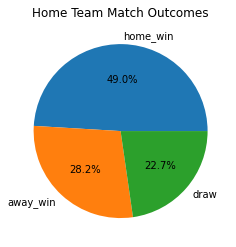

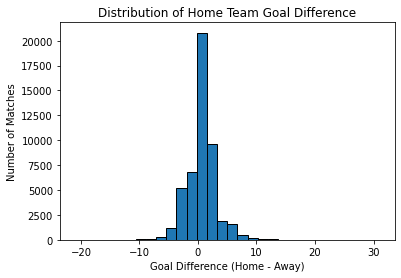


--- No Friendlies ---


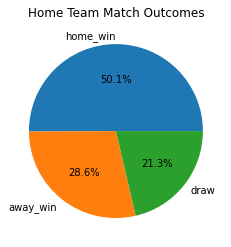

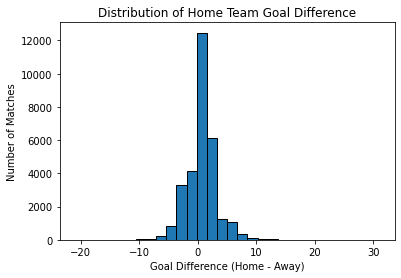


--- No Neutral Matches ---


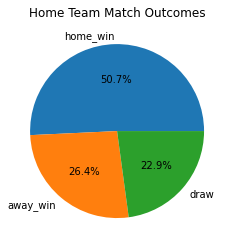

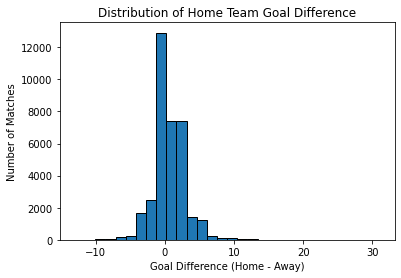


--- No Friendlies and No Neutral Matches ---


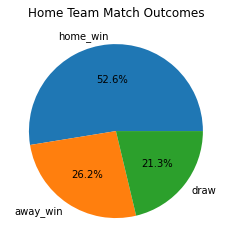

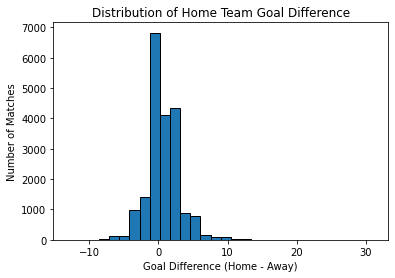

In [9]:


# Plotting
print("--- Original mergedData ---")
plot_home_advantage(mergedData)

print("\n--- No Friendlies ---")
plot_home_advantage(mergedData_no_friendlies)

print("\n--- No Neutral Matches ---")
plot_home_advantage(mergedData_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
plot_home_advantage(mergedData_no_friendlies_no_neutral)


The data suggest the existence of a home advantage, which becomes more pronounced in competitive matches played on non-neutral grounds.
In such matches, there is an increase in home wins, points accumulated, and goal difference in favor of the home team.
Additionally, the likelihood of a draw appears to decrease slightly when the match is competitive.

In [10]:
def analyze_population_impact(results: pd.DataFrame, scale_population: bool = True):
    """
    Analyzes the impact of population difference on home points.
    """

    # 1. Remove NaN populations
    results = remove_nan_population_rows(results.copy())

    # 2. Create population difference
    results['population_difference'] = results['home_population'] - results['away_population']
    if scale_population:
        results['population_difference'] = results['population_difference'] / 1_000_000

    # 3. Prepare data
    X = results[['population_difference']]
    y = results['home_points']

    # 4. Train model
    model = LinearRegression()
    model.fit(X, y)

    # 5. Statsmodels for p-value
    X_with_const = sm.add_constant(X)
    sm_model = sm.OLS(y, X_with_const).fit()

    # 6. Print model info
    print("Linear Regression Model:")
    print(f"Home Points = {model.coef_[0]:.6f} * Population Difference + {model.intercept_:.6f}")
    print(f"R² Score: {model.score(X, y):.4f}")
    print(f"P-value for Population Difference: {sm_model.pvalues['population_difference']:.6f}")

    # 7. Impact conclusion
    print("\nImpact Conclusion:")
    if scale_population:
        print(f"For every 1 million more people at home vs away, home teams earn {model.coef_[0]:.8f} additional points on average.")
    else:
        print(f"For every 1 person more, home teams earn {model.coef_[0]:.8f} additional points on average.")

    # 8. Plot
    predictions = model.predict(X)
    plt.scatter(X, y, alpha=0.3, label="Actual matches")
    plt.plot(X, predictions, color='red', label="Regression Line")
    plt.xlabel('Population Difference (Home - Away) [Millions]' if scale_population else 'Population Difference')
    plt.ylabel('Home Points')
    plt.title('Impact of Population Difference on Home Points')
    plt.legend()
    plt.show()

    return model

--- Original mergedData ---
Linear Regression Model:
Home Points = 0.000613 * Population Difference + 1.701538
R² Score: 0.0030
P-value for Population Difference: 0.000000

Impact Conclusion:
For every 1 million more people at home vs away, home teams earn 0.00061275 additional points on average.


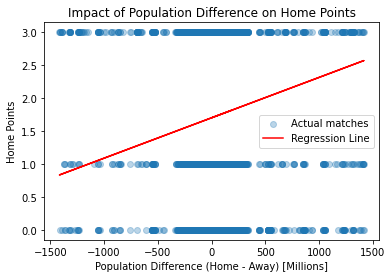


--- No Friendlies ---
Linear Regression Model:
Home Points = 0.000626 * Population Difference + 1.717847
R² Score: 0.0035
P-value for Population Difference: 0.000000

Impact Conclusion:
For every 1 million more people at home vs away, home teams earn 0.00062619 additional points on average.


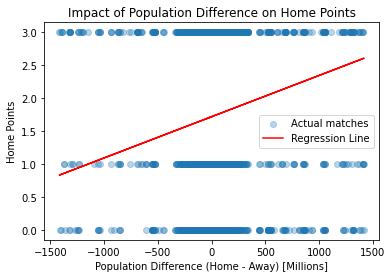


--- No Neutral Matches ---
Linear Regression Model:
Home Points = 0.000719 * Population Difference + 1.759339
R² Score: 0.0040
P-value for Population Difference: 0.000000

Impact Conclusion:
For every 1 million more people at home vs away, home teams earn 0.00071881 additional points on average.


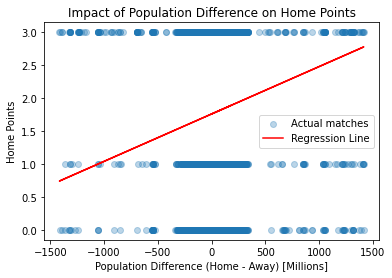


--- No Friendlies and No Neutral Matches ---
Linear Regression Model:
Home Points = 0.000728 * Population Difference + 1.794364
R² Score: 0.0047
P-value for Population Difference: 0.000000

Impact Conclusion:
For every 1 million more people at home vs away, home teams earn 0.00072838 additional points on average.


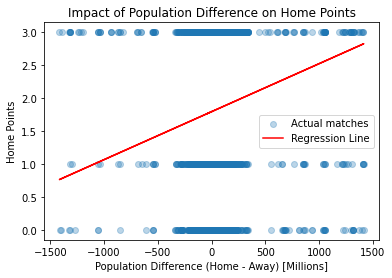

In [11]:
print("--- Original mergedData ---")
modelPop = analyze_population_impact(mergedData)

print("\n--- No Friendlies ---")
modelPop_no_friendlies = analyze_population_impact(mergedData_no_friendlies)

print("\n--- No Neutral Matches ---")
modelPop_no_neutral = analyze_population_impact(mergedData_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
modelPop_no_friendlies_no_neutral = analyze_population_impact(mergedData_no_friendlies_no_neutral)


In [12]:
def analyze_ranking_impact(results: pd.DataFrame):
    """
    Analyzes the impact of ranking difference on home points.
    """

    # 1. Remove NaN rankings
    results = remove_nan_fifa_ranking_rows(results.copy())

    # 2. Create ranking difference
    results['ranking_difference'] = results['away_ranking'] - results['home_ranking']
    # Notice: Higher ranking (smaller number) is better, so flip away - home.

    # 3. Prepare data
    X = results[['ranking_difference']]
    y = results['home_points']

    # 4. Train model
    model = LinearRegression()
    model.fit(X, y)

    # 5. Predictions
    predictions = model.predict(X)

    # 6. Print model info
    print("Linear Regression Model:")
    print(f"Home Points = {model.coef_[0]:.6f} * Ranking Difference + {model.intercept_:.6f}")
    print(f"R² Score: {model.score(X, y):.4f}")

    # 7. Impact explanation
    print("\nImpact:")
    print(f"For every 1 place better home ranking vs away, home teams earn {model.coef_[0]:.6} additional points on average.")

    # 8. Plot
    plt.scatter(X, y, alpha=0.3, label="Actual matches")
    plt.plot(X, predictions, color='red', label="Regression Line")
    plt.xlabel('Ranking Difference (Away Rank - Home Rank)')
    plt.ylabel('Home Points')
    plt.title('Impact of Ranking Difference on Home Points')
    plt.legend()
    plt.show()

    return model


--- Original mergedData ---
Linear Regression Model:
Home Points = 0.010210 * Ranking Difference + 1.659660
R² Score: 0.1888

Impact:
For every 1 place better home ranking vs away, home teams earn 0.0102101 additional points on average.


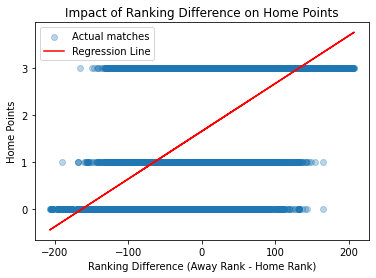


--- No Friendlies ---
Linear Regression Model:
Home Points = 0.010522 * Ranking Difference + 1.671094
R² Score: 0.2240

Impact:
For every 1 place better home ranking vs away, home teams earn 0.0105218 additional points on average.


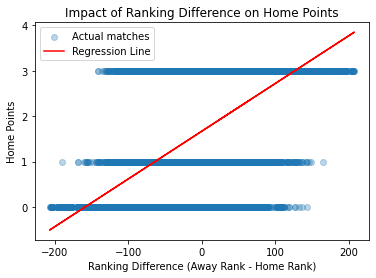


--- No Neutral Matches ---
Linear Regression Model:
Home Points = 0.010154 * Ranking Difference + 1.718251
R² Score: 0.2002

Impact:
For every 1 place better home ranking vs away, home teams earn 0.0101541 additional points on average.


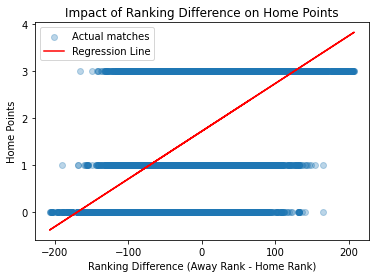


--- No Friendlies and No Neutral Matches ---
Linear Regression Model:
Home Points = 0.010571 * Ranking Difference + 1.744595
R² Score: 0.2544

Impact:
For every 1 place better home ranking vs away, home teams earn 0.0105708 additional points on average.


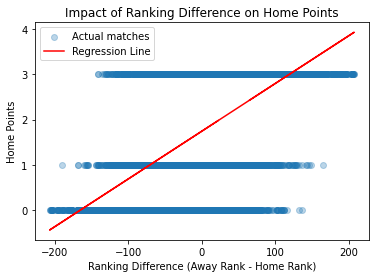

In [13]:
print("--- Original mergedData ---")
modelRank = analyze_ranking_impact(mergedData)

print("\n--- No Friendlies ---")
modelRank_no_friendlies = analyze_ranking_impact(mergedData_no_friendlies)

print("\n--- No Neutral Matches ---")
modelRank_no_neutral = analyze_ranking_impact(mergedData_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
modelRank_no_friendlies_no_neutral = analyze_ranking_impact(mergedData_no_friendlies_no_neutral)


In [14]:
def analyze_combined_impact(results: pd.DataFrame, scale_population: bool = True):
    """
    Analyzes the combined impact of population difference and ranking difference on home points.
    """

    # 1. Remove NaN
    results = results.dropna(subset=['home_population', 'away_population', 'home_ranking', 'away_ranking']).copy()

    # 2. Create features
    results['population_difference'] = results['home_population'] - results['away_population']
    results['ranking_difference'] = results['away_ranking'] - results['home_ranking']

    if scale_population:
        results['population_difference'] = results['population_difference'] / 1_000_000

    # 3. Prepare data
    X = results[['population_difference', 'ranking_difference']]
    y = results['home_points']

    # 4. Train model
    model = LinearRegression()
    model.fit(X, y)

    # 5. Statsmodels for p-value
    X_with_const = sm.add_constant(X)
    sm_model = sm.OLS(y, X_with_const).fit()

    # 6. Print model info
    print("Multiple Linear Regression Model:")
    print(f"Home Points = ({model.coef_[0]:.6f} * Population Difference) + ({model.coef_[1]:.6f} * Ranking Difference) + {model.intercept_:.6f}")
    print(f"R² Score: {model.score(X, y):.4f}")
    print(f"P-value for Population Difference: {sm_model.pvalues['population_difference']:.6f}")
    print(f"P-value for Ranking Difference: {sm_model.pvalues['ranking_difference']:.6f}")

    # 7. Impact conclusion
    print("\nImpact Conclusion:")
    if scale_population:
        print(f"For every 1 million more people (home vs away), home teams earn {model.coef_[0]:.8f} additional points.")
    else:
        print(f"For every 1 person more (home vs away), home teams earn {model.coef_[0]:.8f} additional points.")
    
    print(f"For every 1 place better home ranking vs away, home teams earn {model.coef_[1]:.6f} additional points.")

    # 8. 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(results['population_difference'], results['ranking_difference'], y, alpha=0.3, label='Actual matches')

    x_surf, y_surf = np.meshgrid(
        np.linspace(results['population_difference'].min(), results['population_difference'].max(), 100),
        np.linspace(results['ranking_difference'].min(), results['ranking_difference'].max(), 100)
    )
    z_surf = model.intercept_ + model.coef_[0] * x_surf + model.coef_[1] * y_surf

    ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.5)
    ax.set_xlabel('Population Difference (Millions)' if scale_population else 'Population Difference')
    ax.set_ylabel('Ranking Difference')
    ax.set_zlabel('Home Points')
    ax.set_title('3D Impact of Population and Ranking Differences')
    plt.show()

    return model

--- Original mergedData ---
Multiple Linear Regression Model:
Home Points = (0.000035 * Population Difference) + (0.010138 * Ranking Difference) + 1.664487
R² Score: 0.1899
P-value for Population Difference: 0.531388
P-value for Ranking Difference: 0.000000

Impact Conclusion:
For every 1 million more people (home vs away), home teams earn 0.00003522 additional points.
For every 1 place better home ranking vs away, home teams earn 0.010138 additional points.


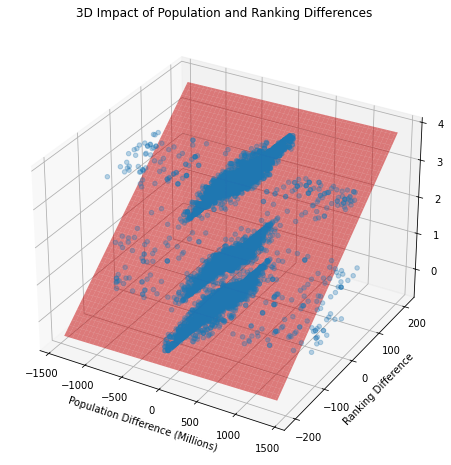


--- No Friendlies ---
Multiple Linear Regression Model:
Home Points = (0.000048 * Population Difference) + (0.010488 * Ranking Difference) + 1.676303
R² Score: 0.2265
P-value for Population Difference: 0.465566
P-value for Ranking Difference: 0.000000

Impact Conclusion:
For every 1 million more people (home vs away), home teams earn 0.00004801 additional points.
For every 1 place better home ranking vs away, home teams earn 0.010488 additional points.


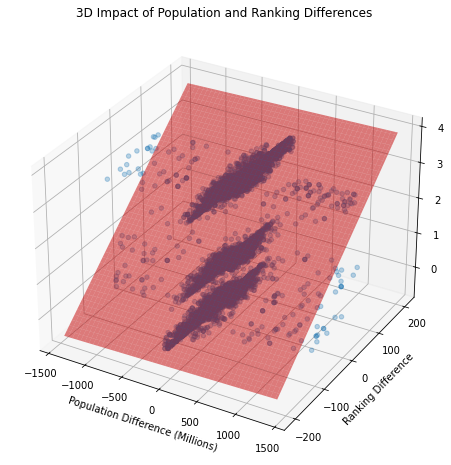


--- No Neutral Matches ---
Multiple Linear Regression Model:
Home Points = (0.000096 * Population Difference) + (0.010033 * Ranking Difference) + 1.726056
R² Score: 0.2016
P-value for Population Difference: 0.152335
P-value for Ranking Difference: 0.000000

Impact Conclusion:
For every 1 million more people (home vs away), home teams earn 0.00009631 additional points.
For every 1 place better home ranking vs away, home teams earn 0.010033 additional points.


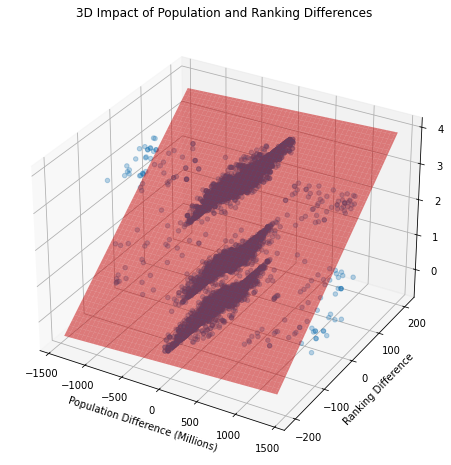


--- No Friendlies and No Neutral Matches ---
Multiple Linear Regression Model:
Home Points = (0.000068 * Population Difference) + (0.010517 * Ranking Difference) + 1.752281
R² Score: 0.2584
P-value for Population Difference: 0.393060
P-value for Ranking Difference: 0.000000

Impact Conclusion:
For every 1 million more people (home vs away), home teams earn 0.00006813 additional points.
For every 1 place better home ranking vs away, home teams earn 0.010517 additional points.


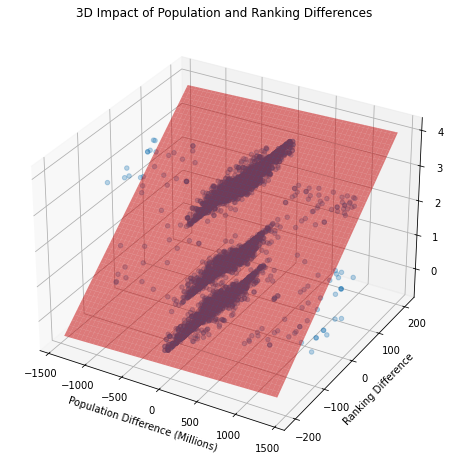

In [15]:
print("--- Original mergedData ---")
modelCombined = analyze_combined_impact(mergedData)

print("\n--- No Friendlies ---")
modelCombined_no_friendlies = analyze_combined_impact(mergedData_no_friendlies)

print("\n--- No Neutral Matches ---")
modelCombined_no_neutral = analyze_combined_impact(mergedData_no_neutral)

print("\n--- No Friendlies and No Neutral Matches ---")
modelCombined_no_friendlies_no_neutral = analyze_combined_impact(mergedData_no_friendlies_no_neutral)


In [16]:
def prepare_classification_target(results: pd.DataFrame) -> pd.DataFrame:
    
    results = results.copy()
    results['home_win'] = results['outcome'].apply(lambda x: 1 if x == 'home_win' else 0)
    return results

    
def run_logistic_regression(results: pd.DataFrame):
    """
    Runs Logistic Regression to predict home win based on population and ranking differences.
    Includes a probability distribution plot.
    """

    # Prepare dataset
    results = results.dropna(subset=['population_difference', 'ranking_difference'])
    results = prepare_classification_target(results)
    X = results[['population_difference', 'ranking_difference']]
    y = results['home_win']

    # Train model
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)

    # Predict and evaluate
    predictions = model.predict(X)

    acc = accuracy_score(y, predictions)
    cm = confusion_matrix(y, predictions)
    report = classification_report(y, predictions)

    print("=== Logistic Regression Results ===")
    print(f"Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)

    # Predicted probabilities
    probs = model.predict_proba(X)[:, 1]  # probability of home win

    plt.figure(figsize=(8,6))
    plt.hist(probs, bins=30, edgecolor='black')
    plt.xlabel('Predicted Probability of Home Win')
    plt.ylabel('Number of Matches')
    plt.title('Logistic Regression: Predicted Probabilities')
    plt.grid()
    plt.show()

    return model
    

def run_random_forest_regression(results: pd.DataFrame):
    """
    Runs Random Forest Regression to predict home points based on population and ranking differences.
    Includes scatter plot of true vs predicted points and a visualization of a decision tree.
    """
    from sklearn.tree import plot_tree

    # Prepare dataset
    results = results.dropna(subset=['population_difference', 'ranking_difference'])
    X = results[['population_difference', 'ranking_difference']]
    y = results['home_points']

    # Train model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Predict and evaluate
    predictions = model.predict(X)

    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)

    print("=== Random Forest Regression Results ===")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Feature importances
    feature_importances = model.feature_importances_
    for feat, importance in zip(X.columns, feature_importances):
        print(f"{feat}: {importance:.4f}")

    # --- Scatter plot: Actual vs Predicted ---
    plt.figure(figsize=(8,6))
    plt.scatter(y, predictions, alpha=0.5)
    plt.plot([0, 3], [0, 3], 'r--')  # ideal line
    plt.xlabel('Actual Home Points')
    plt.ylabel('Predicted Home Points')
    plt.title('Random Forest: Actual vs Predicted Home Points')
    plt.grid()
    plt.show()

    # --- Visualize one Decision Tree inside the Forest ---
    estimator = model.estimators_[0]  # Pick the first tree for visualization

    plt.figure(figsize=(20, 10))
    plot_tree(
        estimator,
        feature_names=X.columns,
        filled=True,
        rounded=True,
        max_depth=3,  # Only show first 3 levels to keep it readable
        fontsize=10
    )
    plt.title('Visualization of one Decision Tree inside Random Forest')
    plt.show()

    return model





--- Logistic Regression: Original mergedData ---
=== Logistic Regression Results ===
Accuracy: 0.6691
Confusion Matrix:
[[ 9596  5529]
 [ 4195 10063]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.63      0.66     15125
           1       0.65      0.71      0.67     14258

    accuracy                           0.67     29383
   macro avg       0.67      0.67      0.67     29383
weighted avg       0.67      0.67      0.67     29383



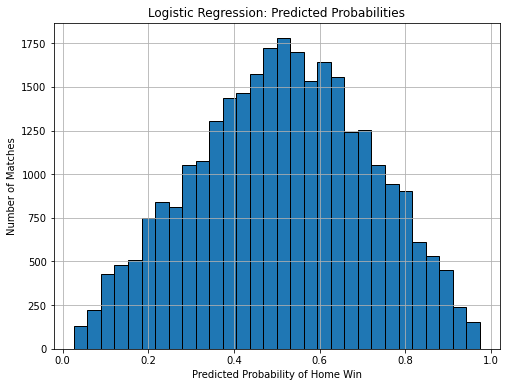


--- Random Forest Regression: Original mergedData ---
=== Random Forest Regression Results ===
Mean Squared Error: 0.5574
R² Score: 0.6779
population_difference: 0.5758
ranking_difference: 0.4242


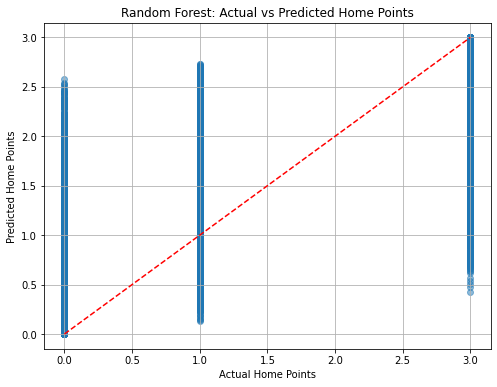

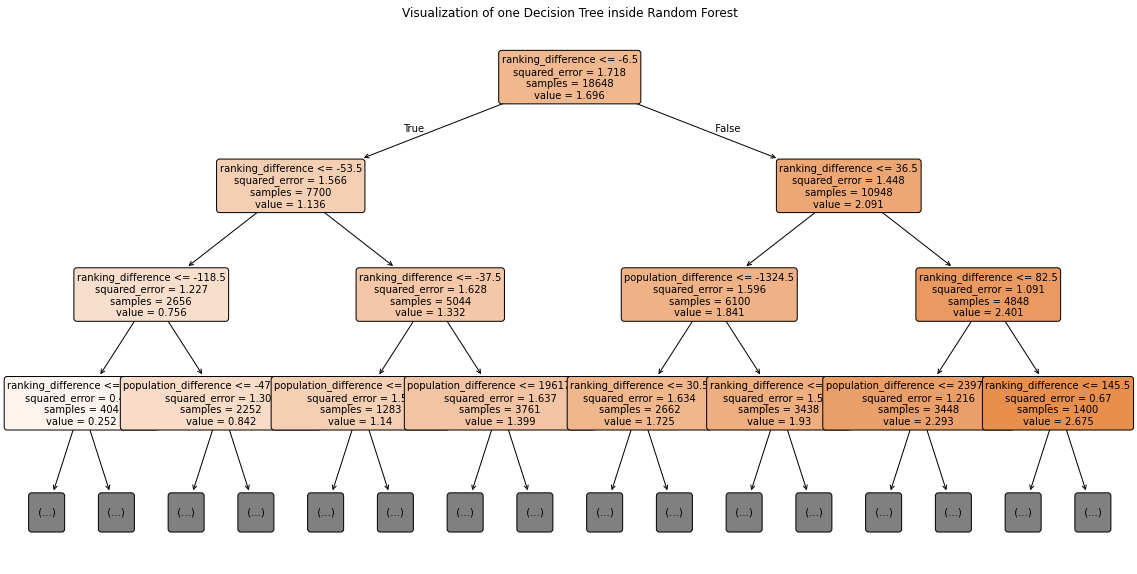


--- Logistic Regression: No Friendlies ---
=== Logistic Regression Results ===
Accuracy: 0.6875
Confusion Matrix:
[[6321 3238]
 [2658 6649]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      9559
           1       0.67      0.71      0.69      9307

    accuracy                           0.69     18866
   macro avg       0.69      0.69      0.69     18866
weighted avg       0.69      0.69      0.69     18866



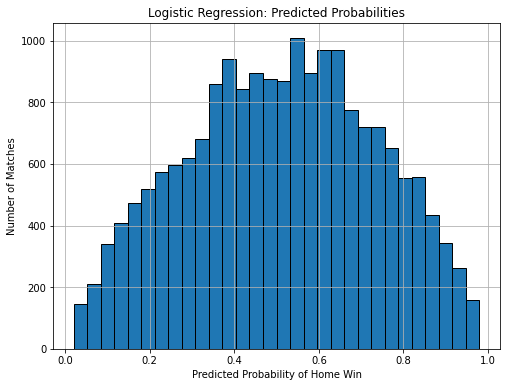


--- Random Forest Regression: No Friendlies ---
=== Random Forest Regression Results ===
Mean Squared Error: 0.4740
R² Score: 0.7309
population_difference: 0.5426
ranking_difference: 0.4574


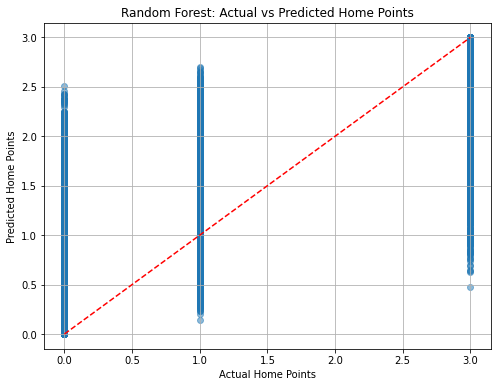

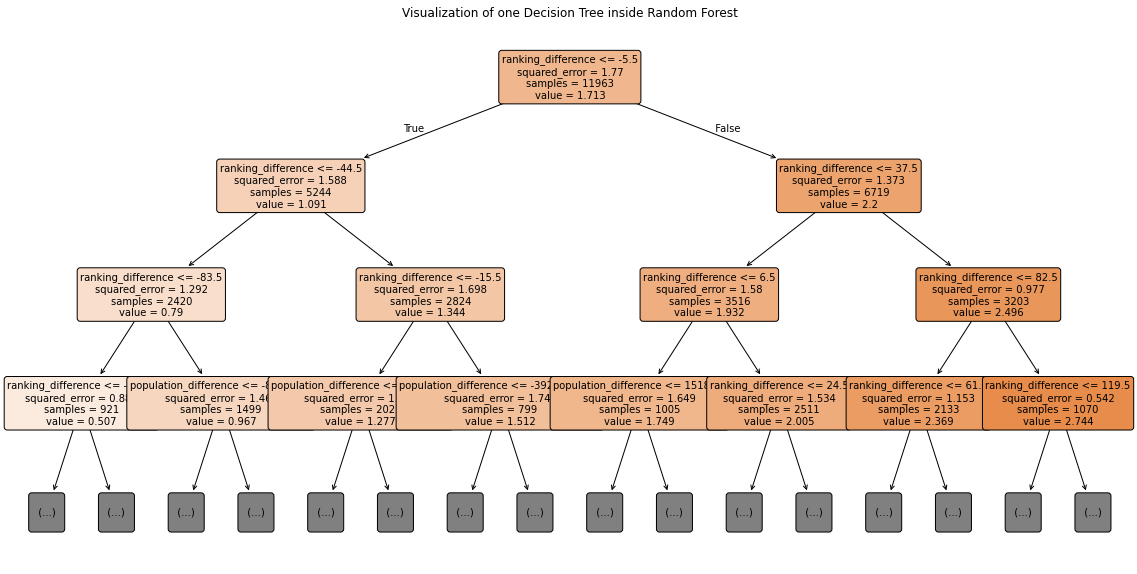


--- Logistic Regression: No Neutral Matches ---
=== Logistic Regression Results ===
Accuracy: 0.6762
Confusion Matrix:
[[6870 3749]
 [3229 7704]]

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.65      0.66     10619
           1       0.67      0.70      0.69     10933

    accuracy                           0.68     21552
   macro avg       0.68      0.68      0.68     21552
weighted avg       0.68      0.68      0.68     21552



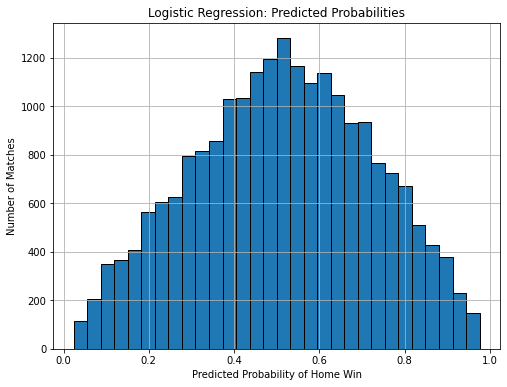


--- Random Forest Regression: No Neutral Matches ---
=== Random Forest Regression Results ===
Mean Squared Error: 0.4880
R² Score: 0.7133
population_difference: 0.5643
ranking_difference: 0.4357


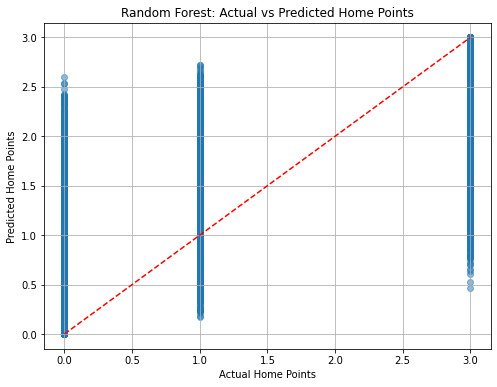

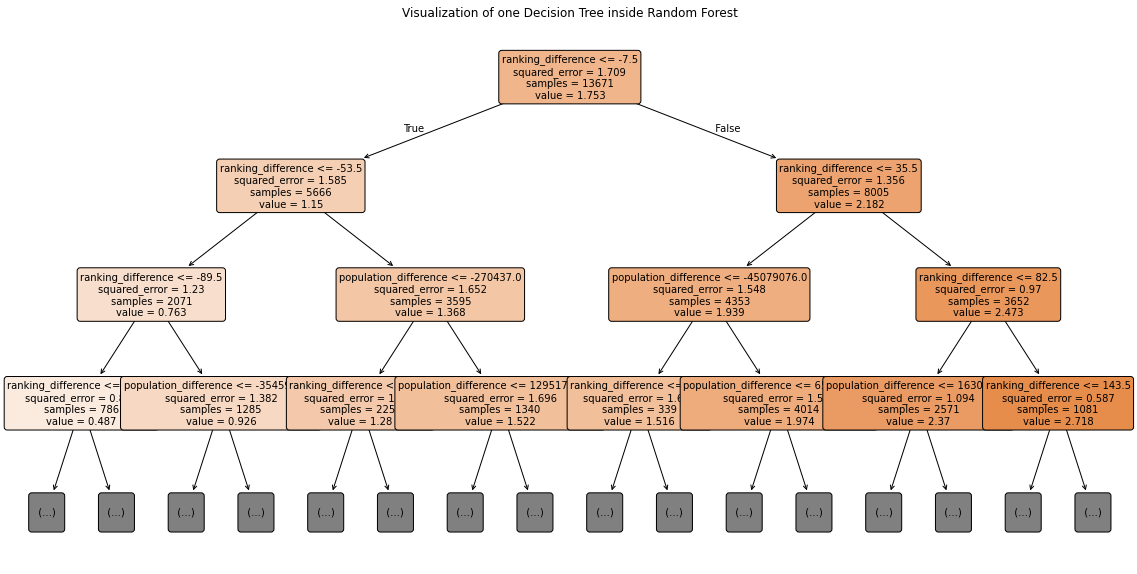


--- Logistic Regression: No Friendlies and No Neutral Matches ---
=== Logistic Regression Results ===
Accuracy: 0.7058
Confusion Matrix:
[[4252 1907]
 [1877 4824]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      6159
           1       0.72      0.72      0.72      6701

    accuracy                           0.71     12860
   macro avg       0.71      0.71      0.71     12860
weighted avg       0.71      0.71      0.71     12860



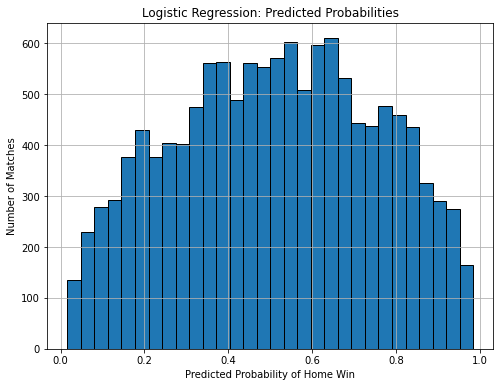


--- Random Forest Regression: No Friendlies and No Neutral Matches ---
=== Random Forest Regression Results ===
Mean Squared Error: 0.3767
R² Score: 0.7822
population_difference: 0.5167
ranking_difference: 0.4833


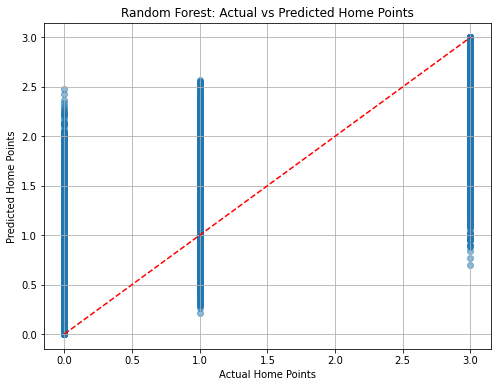

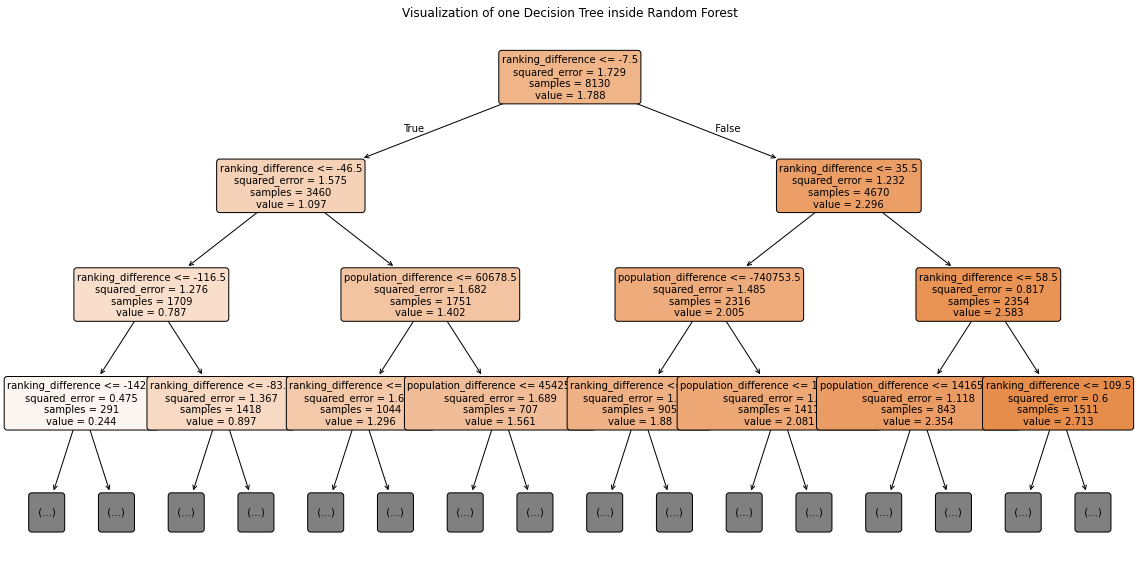


=== Summary Table ===
                                      Logistic Regression Accuracy  \
Original mergedData                                       0.669060   
No Friendlies                                             0.687480   
No Neutral Matches                                        0.676225   
No Friendlies and No Neutral Matches                      0.705754   

                                      Random Forest Regression R² Score  
Original mergedData                                            0.677895  
No Friendlies                                                  0.730912  
No Neutral Matches                                             0.713276  
No Friendlies and No Neutral Matches                           0.782154  


In [17]:
# --- Step 1: Make sure difference columns are created for all datasets ---

datasets = {
    'Original mergedData': mergedData,
    'No Friendlies': mergedData_no_friendlies,
    'No Neutral Matches': mergedData_no_neutral,
    'No Friendlies and No Neutral Matches': mergedData_no_friendlies_no_neutral
}

for name, data in datasets.items():
    data['population_difference'] = data['home_population'] - data['away_population']
    data['ranking_difference'] = data['away_ranking'] - data['home_ranking']

# --- Step 2: Run models for all datasets and store results ---

logistic_models = {}
random_forest_models = {}
logistic_accuracies = {}
random_forest_r2_scores = {}

for name, data in datasets.items():
    print(f"\n--- Logistic Regression: {name} ---")
    logistic_model = run_logistic_regression(data)
    logistic_models[name] = logistic_model

    print(f"\n--- Random Forest Regression: {name} ---")
    random_forest_model = run_random_forest_regression(data)
    random_forest_models[name] = random_forest_model
    
    # Prepare X and y cleanly for scoring:
    X_log = data[['population_difference', 'ranking_difference']].dropna()
    y_log = prepare_classification_target(data.dropna(subset=['population_difference', 'ranking_difference']))['home_win']
    logistic_accuracies[name] = accuracy_score(y_log, logistic_model.predict(X_log))

    X_rf = data[['population_difference', 'ranking_difference']].dropna()
    y_rf = data.dropna(subset=['population_difference', 'ranking_difference'])['home_points']
    random_forest_r2_scores[name] = r2_score(y_rf, random_forest_model.predict(X_rf))


summary = pd.DataFrame({
    'Logistic Regression Accuracy': logistic_accuracies,
    'Random Forest Regression R² Score': random_forest_r2_scores
})

print("\n=== Summary Table ===")
print(summary)


In [18]:
# Define the new match input
new_data = pd.DataFrame({
    'population_difference': [100],
    'ranking_difference': [25]
})

# Pull all models properly
model_sets = {
    'Original mergedData': (logistic_models['Original mergedData'], random_forest_models['Original mergedData'], modelCombined),
    'No Friendlies': (logistic_models['No Friendlies'], random_forest_models['No Friendlies'], modelCombined_no_friendlies),
    'No Neutral Matches': (logistic_models['No Neutral Matches'], random_forest_models['No Neutral Matches'], modelCombined_no_neutral),
    'No Friendlies and No Neutral Matches': (logistic_models['No Friendlies and No Neutral Matches'], random_forest_models['No Friendlies and No Neutral Matches'], modelCombined_no_friendlies_no_neutral)
}

# Run predictions for each model set
for name, (logistic_model, rf_model, combined_model) in model_sets.items():
    print(f"\n=== Predictions using model: {name} ===")
    
    # Logistic Regression prediction (Home Win)
    predicted_home_win = logistic_model.predict(new_data)
    print(f"Predicted outcome (1 = Home win, 0 = Not Home win): {predicted_home_win[0]}")
    
    # Random Forest Regression prediction (Home Points)
    predicted_home_points_rf = rf_model.predict(new_data)
    print(f"Predicted home points (Random Forest): {predicted_home_points_rf[0]:.4f}")
    
    # Combined Linear Regression prediction (Home Points)
    predicted_home_points_combined = combined_model.predict(new_data)
    print(f"Predicted home points (Combined Linear Regression): {predicted_home_points_combined[0]:.4f}")



=== Predictions using model: Original mergedData ===
Predicted outcome (1 = Home win, 0 = Not Home win): 1
Predicted home points (Random Forest): 2.1225
Predicted home points (Combined Linear Regression): 1.9215

=== Predictions using model: No Friendlies ===
Predicted outcome (1 = Home win, 0 = Not Home win): 1
Predicted home points (Random Forest): 2.1505
Predicted home points (Combined Linear Regression): 1.9433

=== Predictions using model: No Neutral Matches ===
Predicted outcome (1 = Home win, 0 = Not Home win): 1
Predicted home points (Random Forest): 2.2283
Predicted home points (Combined Linear Regression): 1.9865

=== Predictions using model: No Friendlies and No Neutral Matches ===
Predicted outcome (1 = Home win, 0 = Not Home win): 1
Predicted home points (Random Forest): 2.3390
Predicted home points (Combined Linear Regression): 2.0220


In [36]:
# Define the match data
matches = {
    'Denmark vs England': pd.DataFrame({
        'population_difference': [-52.057728],
        'ranking_difference': [-18]
    }),
    'England vs Denmark': pd.DataFrame({
        'population_difference': [52.057728],
        'ranking_difference': [18]
    }),
    'Spain vs Germany': pd.DataFrame({
        'population_difference': [47.889958-84.075075],
        'ranking_difference': [8]
    }),
    'Germany vs Spain': pd.DataFrame({
        'population_difference': [84.075075-47.889958],
        'ranking_difference': [-8]
    }),
}

# Store results
prediction_results = []

# Loop over matches and model sets
for match_name, match_data in matches.items():
    for dataset_name, (logistic_model, rf_model, combined_model) in model_sets.items():
        predicted_home_win = logistic_model.predict(match_data)[0]
        predicted_home_points_rf = rf_model.predict(match_data)[0]
        predicted_home_points_linear = combined_model.predict(match_data)[0]

        prediction_results.append({
            'Match': match_name,
            'Dataset': dataset_name,
            'Predicted Home Win (1=Yes) (Logistic model)': int(predicted_home_win),
            'Home Points (Random Forest)': round(predicted_home_points_rf, 2),
            'Home Points (Linear Regression)': round(predicted_home_points_linear, 2)
        })

# Create DataFrame
summary_df = pd.DataFrame(prediction_results)

# Reorder columns a bit
summary_df = summary_df[['Match', 'Dataset', 
                         'Predicted Home Win (1=Yes) (Logistic model)', 
                         'Home Points (Random Forest)', 
                         'Home Points (Linear Regression)']]

# Show it nicely in Jupyter
display(summary_df)

,Match,Dataset,Predicted Home Win (1=Yes) (Logistic model),Home Points (Random Forest),Home Points (Linear Regression)
0,Denmark vs England,Original mergedData,0,1.06,1.48
1,Denmark vs England,No Friendlies,0,1.31,1.49
2,Denmark vs England,No Neutral Matches,0,1.34,1.54
3,Denmark vs England,No Friendlies and No Neutral Matches,0,1.33,1.56
4,England vs Denmark,Original mergedData,1,1.37,1.85
5,England vs Denmark,No Friendlies,1,2.02,1.87
6,England vs Denmark,No Neutral Matches,1,1.68,1.91
7,England vs Denmark,No Friendlies and No Neutral Matches,1,1.72,1.95
8,Spain vs Germany,Original mergedData,1,1.93,1.74
9,Spain vs Germany,No Friendlies,1,1.50,1.76
